# Data scraping and storing

In [34]:
import requests
import sqlite3

from bs4 import BeautifulSoup as bs
from shapely.geometry import Point
from pyproj import Transformer
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

### 1. Extract public data from Georgia's natioal seismic monitoring centre website

In [35]:
#creating a function to extract earthquakes tabular data from specific url and put it into pandas dataframe
def make_earthquake_dataframe(url):
    page=requests.get(url)
    soup=bs(page.text, 'html.parser')

    #get necessary table from the page
    tables=soup.find_all('table')
    quake_table=tables[1]

    #the tag of every column is 'th'; create a list of columns
    #strip col names to prevent accidental whitespaces
    columns=[i.text.strip() for i in quake_table.find_all('th')]

    scraped_data = pd.DataFrame(columns=columns)
    for i in quake_table.find_all('tr')[1:]:
        row_data=i.find_all('td')
        row=[i.text for i in row_data]
        length=len(scraped_data)
        scraped_data.loc[length]=row

    return scraped_data

In [36]:
# create a list of urls of 10 different pages of same website containing table
urls=[f'https://ies.iliauni.edu.ge/?page_id=183&paged={str(i)}&lang=en' for i in range(1,11)]

In [37]:
#create dataframes from different pages and concatenate them into single dataframe
scraped_dfs=[]

try:
    for i in urls:
        scraped_dfs.append(make_earthquake_dataframe(i))
except:
    pass        

scraped_df=pd.concat(scraped_dfs)

In [38]:
#convert time column from object to datetime
scraped_df['Time(UTC)']=pd.to_datetime(scraped_df['Time(UTC)'], format='mixed')

### 2. Store data in a local database

Newly scraped and existing data are compared and if any new data has been accumulated on website we'll add it to database

In [39]:
#make database connection and read date column for comparison
conn = sqlite3.connect('geo_earthquakes.db')
curs=conn.cursor()

curs.execute("""
             CREATE TABLE IF NOT EXISTS "Earthquakes" (
             "Time(UTC)" TEXT,
             "Magnitude(ml)" TEXT,
             "Fm" TEXT,
             "Depth(km)" TEXT,
             "Lat/Long(degree)" TEXT,
             "Region" TEXT,
             "M/A" TEXT
             )""")

stored_dates_str = pd.read_sql('select * from Earthquakes', conn)['Time(UTC)']
stored_dates = pd.to_datetime(stored_dates_str, format='mixed')

In [40]:
#write scraped data to database if database is empty
if stored_dates.empty:
    scraped_df.to_sql('Earthquakes', conn, if_exists='append', index=False)
    conn.close()    
else:
    #if database has entries, compare their most recent date with scraped date values and return only new data
    new_data = scraped_df[scraped_df['Time(UTC)']>stored_dates.max()]

    #if there's no new data then no action is needed, otherwise add new data to database
    if new_data.empty:
        conn.close()
        pass
    else:
        curs=conn.cursor()
        new_data.to_sql('Earthquakes', conn, if_exists='append', index=False)
        conn.close()

# Data Cleaning and Analysis

In [41]:
#read full database as a dataframe
conn=sqlite3.connect('geo_earthquakes.db')
df=pd.read_sql('select * from Earthquakes order by "Time(UTC)" desc', conn)
conn.close()

In [42]:
df[['lat', 'long']]=df['Lat/Long(degree)'].str.split('/', expand=True)
# df.drop(columns='Lat/Long(degree)', axis=1, inplace=True)

In [43]:
df.head(4)

,Time(UTC),Magnitude(ml),Fm,Depth(km),Lat/Long(degree),Region,M/A,lat,long
0,2024-03-22 10:24:17,4.1,,2,42.846/45.68,Russia. Chechnia. From Georgia border - 34km. ...,M,42.846,45.68
1,2024-03-20 16:07:57,3.1,,10,41.4005/44.028,From Tbilisi – 59km. City Dmanisi - West - 14k...,M,41.4005,44.028
2,2024-03-19 23:07:09,3.6,,43,41.8608/45.872,City Kvareli - South-East - 8km. Village Gava...,M,41.8608,45.872
3,2024-03-05 00:39:19,3.2,,11,43.4813/40.8143,City Gudauta - North-East - 41km. Village Agh...,M,43.4813,40.8143


In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316 entries, 0 to 315
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Time(UTC)         316 non-null    object
 1   Magnitude(ml)     316 non-null    object
 2   Fm                316 non-null    object
 3   Depth(km)         316 non-null    object
 4   Lat/Long(degree)  316 non-null    object
 5   Region            316 non-null    object
 6   M/A               316 non-null    object
 7   lat               316 non-null    object
 8   long              316 non-null    object
dtypes: object(9)
memory usage: 22.3+ KB


### 3. Create a column of Georgia's regions, corresponding each earthquake epicenter

We use geopandas and geojson file to put each epicenter in respective Georgian region.
Credit to David Bumbeishvili for geojson file (https://github.com/bumbeishvili/geojson-georgian-regions)

In [45]:
#create a geopandas geodataframe from geojson file
georgia_regions='regions.geojson'
regions_gdf = gpd.read_file(georgia_regions)
regions_gdf.head(3)
# Note that multipolygon coordinates are in metric format

,OBJECTID,REGION_ENG,SHAPE_Leng,SHAPE_Area,Name,geometry
0,1,Ajara,298588.600485,2.896066e+09,aWara,"MULTIPOLYGON (((232697.453 4643237.628, 232759..."
1,2,Samegrelo-zemo Svaneti,598743.730516,7.509961e+09,samegrelo-zemo svaneTi,"MULTIPOLYGON (((291091.999 4792166.291, 291154..."
2,3,Guria,253254.283249,2.030642e+09,guria,"MULTIPOLYGON (((247684.746 4673002.114, 247859..."


In [46]:
#convert lat and long columns into shapely's point object
geometry = [Point(xy) for xy in zip(df['long'], df['lat'])]

#create a geodataframe containing points
points_gdf = gpd.GeoDataFrame(df, geometry=geometry, crs=regions_gdf.crs)

In [47]:
#create a transformer and transform points from lat long to metric format
transformer = Transformer.from_crs("EPSG:4326", regions_gdf.crs, always_xy=True)
points_gdf['geometry'] = [Point(transformer.transform(x, y)) for x, y in zip(points_gdf['long'], points_gdf['lat'])]
points_gdf.head(3)

,Time(UTC),Magnitude(ml),Fm,Depth(km),Lat/Long(degree),Region,M/A,lat,long,geometry
0,2024-03-22 10:24:17,4.1,,2,42.846/45.68,Russia. Chechnia. From Georgia border - 34km. ...,M,42.846,45.68,POINT (555563.999 4743937.816)
1,2024-03-20 16:07:57,3.1,,10,41.4005/44.028,From Tbilisi – 59km. City Dmanisi - West - 14k...,M,41.4005,44.028,POINT (418749.640 4583673.709)
2,2024-03-19 23:07:09,3.6,,43,41.8608/45.872,City Kvareli - South-East - 8km. Village Gava...,M,41.8608,45.872,POINT (572374.454 4634688.735)


In [48]:
#make a spatial join
join_gdf = gpd.sjoin(points_gdf, regions_gdf, how='left', predicate='within')
join_gdf.head(3)

,Time(UTC),Magnitude(ml),Fm,Depth(km),Lat/Long(degree),Region,M/A,lat,long,geometry,index_right,OBJECTID,REGION_ENG,SHAPE_Leng,SHAPE_Area,Name
0,2024-03-22 10:24:17,4.1,,2,42.846/45.68,Russia. Chechnia. From Georgia border - 34km. ...,M,42.846,45.68,POINT (555563.999 4743937.816),NaN,NaN,NaN,NaN,NaN,NaN
1,2024-03-20 16:07:57,3.1,,10,41.4005/44.028,From Tbilisi – 59km. City Dmanisi - West - 14k...,M,41.4005,44.028,POINT (418749.640 4583673.709),8.0,9.0,Kvemo Kartli,576129.346807,6.296913e+09,qvemo qarTli
2,2024-03-19 23:07:09,3.6,,43,41.8608/45.872,City Kvareli - South-East - 8km. Village Gava...,M,41.8608,45.872,POINT (572374.454 4634688.735),7.0,8.0,Kakheti,792608.706853,1.133322e+10,kaxeTi


In [49]:
# Extract the region column from the joint GeoDataFrame and put it in main dataframe
df['ge_region'] = join_gdf['REGION_ENG']
df.head(3)

,Time(UTC),Magnitude(ml),Fm,Depth(km),Lat/Long(degree),Region,M/A,lat,long,ge_region
0,2024-03-22 10:24:17,4.1,,2,42.846/45.68,Russia. Chechnia. From Georgia border - 34km. ...,M,42.846,45.68,NaN
1,2024-03-20 16:07:57,3.1,,10,41.4005/44.028,From Tbilisi – 59km. City Dmanisi - West - 14k...,M,41.4005,44.028,Kvemo Kartli
2,2024-03-19 23:07:09,3.6,,43,41.8608/45.872,City Kvareli - South-East - 8km. Village Gava...,M,41.8608,45.872,Kakheti


In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316 entries, 0 to 315
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Time(UTC)         316 non-null    object
 1   Magnitude(ml)     316 non-null    object
 2   Fm                316 non-null    object
 3   Depth(km)         316 non-null    object
 4   Lat/Long(degree)  316 non-null    object
 5   Region            316 non-null    object
 6   M/A               316 non-null    object
 7   lat               316 non-null    object
 8   long              316 non-null    object
 9   ge_region         188 non-null    object
dtypes: object(10)
memory usage: 24.8+ KB


### Plot earthquakes on map

Text(0.5, 1.0, 'Earthquakes in Georgia')

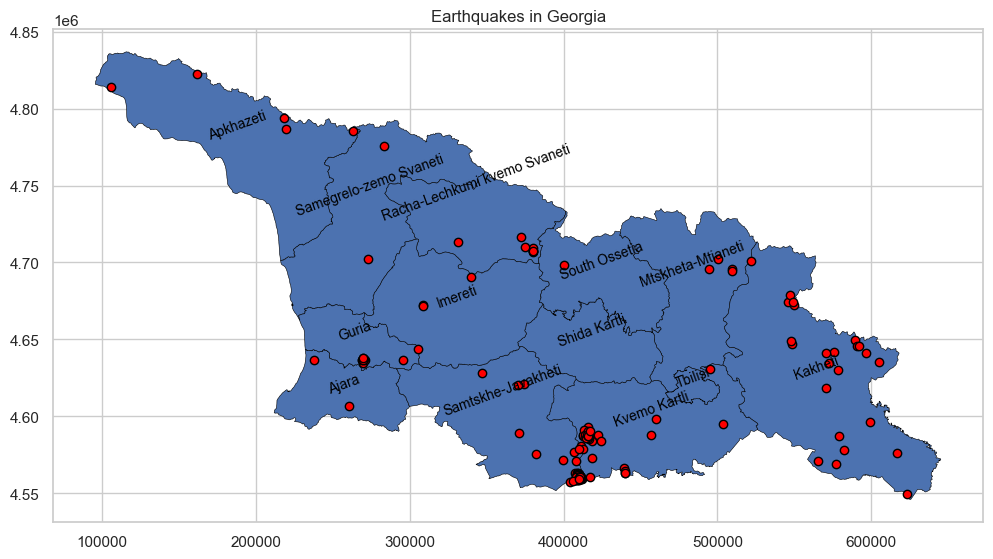

In [51]:
ax = regions_gdf.plot(figsize=(12,12), edgecolor='black', linewidth=0.4)

regions_gdf.apply(lambda x: ax.annotate(text=x['REGION_ENG'], xy=x.geometry.centroid.coords[0],\
                                         ha='center', fontsize='small', rotation=20, color='black'), axis=1)

# Using joint geodataframe we'll extract and plot earthquakes having epicenters on georgian territory
# If geo_region has no value it means epicenter was outside of Georgia
join_gdf[join_gdf['Name'].notna()].plot(ax=ax, color='red', edgecolor='black')

plt.title('Earthquakes in Georgia')

### Miscellanious changes

In [52]:
# Change dataframe columns names to lowercase
df.columns=[col.lower() for col in df.columns]

In [53]:
# Fill empty values: as we saw above empty cells in ge_region means epicenter was abroad
df['ge_region'].fillna('Outside of Georgia', inplace=True)

C:\Users\Irakli\AppData\Local\Temp\ipykernel_13428\3123428814.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['ge_region'].fillna('Outside of Georgia', inplace=True)


In [54]:
# Datetime changes
df['time(utc)']=pd.to_datetime(df['time(utc)'], format='mixed')
df['time(tbilisi)']=df['time(utc)'].dt.tz_localize('UTC').dt.tz_convert('Asia/Tbilisi')

# Change numerical columns to number types
df['magnitude(ml)']=df['magnitude(ml)'].astype(float)
df['depth(km)']=df['depth(km)'].astype(int)

### 4. Analyse data

In [55]:
# Show weakest and strongest earthquake records
print(df['magnitude(ml)'].min())
print(df['magnitude(ml)'].max())

2.3
7.8


Seismically the most active regions

In [56]:
df['ge_region'].value_counts()

ge_region
Outside of Georgia              128
Samtskhe-Javakheti               91
Kvemo Kartli                     34
Kakheti                          23
Guria                            14
Racha-Lechkumi kvemo Svaneti      8
Apkhazeti                         5
Mtskheta-Mtianeti                 5
Imereti                           3
Ajara                             2
Samegrelo-zemo Svaneti            2
South Ossetia                     1
Name: count, dtype: int64

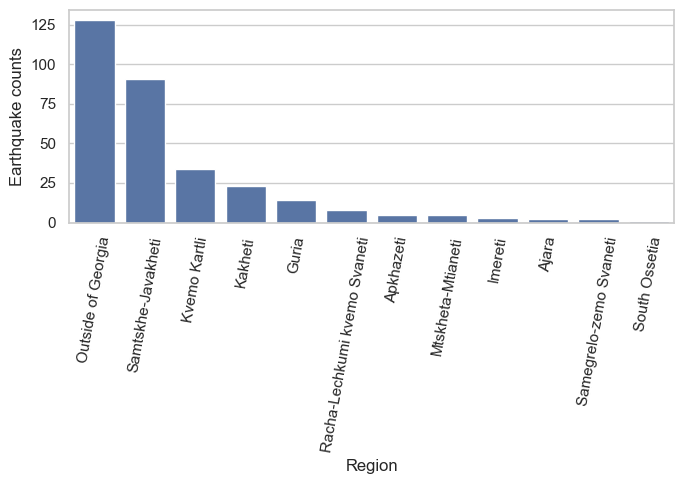

In [57]:
plt.figure(figsize=(7,5))
sns.set_theme(style='whitegrid')
sns.countplot(data=df, x='ge_region', order=df['ge_region'].value_counts().index)
plt.xticks(rotation=80)
plt.xlabel('Region')
plt.ylabel('Earthquake counts')
plt.tight_layout()

We can see that most recorded earthquake epicenters were outside of Georgia.

The most seismically active region has been Samtskhe-Javakheti, with more epicenters than all other regions combined.

Tbilisi - the capital of Georgia, didn't have any recorded 3+ magnitude epicenters for this period.

Note: as new records will be added to the database, the above observations may become more or less incorrect over time.


### Earthquake strength categories in Georgia

In [58]:
# Categorize earthquake strength in Four bins: 3 to 4 magnitude='Medium', 4 to 5='strong', 5 to 6='very strong', >6='destructive
bins=[0,4,5,6,10]
labels=['weak', 'medium', 'strong', 'destructive']
df['ml_category']=pd.cut(df['magnitude(ml)'].astype(float), bins, labels=labels)

In [59]:
# Earthquakes with epicenters in Georgia
ge_df=df[df['ge_region']!='Outside of Georgia']

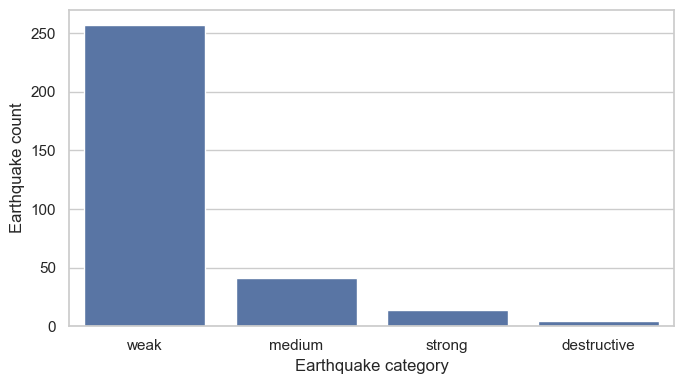

In [60]:
fig=plt.figure(figsize=(7,4))
ml_counts=sns.countplot(data=df, x='ml_category')
plt.xlabel('Earthquake category')
plt.ylabel('Earthquake count')
plt.tight_layout()

### Night/Day?

In [61]:
# I'll categorize time from 00:00 to 08:00 as night and other times as day, based on when humans are asleep/awake generally
df['day/night']=df['time(tbilisi)'].apply(lambda x: 'Night' if 0 < x.hour < 8 else 'Day')

In [62]:
df['day/night'].value_counts()

day/night
Day      222
Night     94
Name: count, dtype: int64

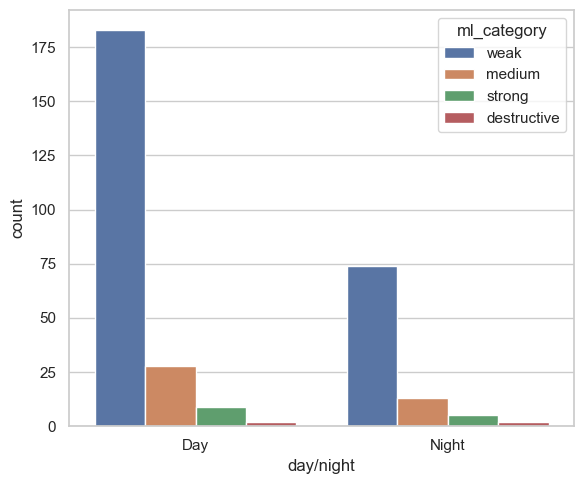

In [63]:
plt.figure(figsize=(6,5))
sns.countplot(data=df, x='day/night', hue='ml_category')
plt.tight_layout()

### Correlation

In [64]:
num_df=df.select_dtypes(include='number')

<Axes: >

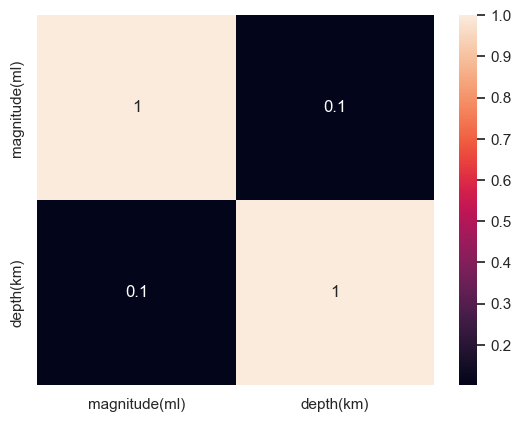

In [65]:
cor=num_df.corr()
sns.heatmap(data=cor, annot=True)

There is no correlation between depth and magnitude

In [66]:
# Remove non English alphabet
df['region'] = df['region'].str.replace(r'[^\x00-\x7F]+', '', regex=True)

### Conclusions:
- First of all we should note that the dataset is very small for any kind of ML;
- There is no correlation between the stength of an earthquake and depth;
- Most recorded earthquakes occured outside of Georgian border;
- The most active regions are Samtskhe_javakheti and Kvemo_kartl, followed by Kakheti. The map shows that most earthquakes are crowded in in the south, on the Javakheti ridge;
- Most earthquakes happened between 08:00 and 00:00 (Tbilisi time), but occurences are mostly evenly distributed in time. 
